# Anomaly Detection

In [11]:
# import sys
import sys
sys.path.append("/home/ladin/Projects/research/botnet-traffic-analysis/")

# Jupyter data visualization
from IPython import display

# data handling
from sklearn.preprocessing import normalize
from sklearn.utils import resample
import numpy as np
import pandas as pd

# machine learning
from sklearn.ensemble import RandomForestClassifier

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import plot, axis, show, pcolor, colorbar, bone
from scipy.stats import gaussian_kde

# SOM
import minisom
import somoclu
from SAD.anomaly_detection import AnomalyDetection

# hyperparameter tuning
from hyperopt import Trials, STATUS_OK, fmin, tpe, hp

# feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# other
import time
import os

In [12]:
from utils.datasets import get_all_files

In [52]:
def plot_som(som, data, target=None):
    plt.figure(figsize=(16, 12))
    bone()
    pcolor(som.distance_map().T)
    colorbar()
    markers = ['o','s','D','+','v','p','*','x']
    colors = ['r','g','b','y','pink','orange','purple','grey']
    if target is not None:
        for cnt, xx in enumerate(data):
            w = som.winner(xx)
            plot(w[0]+.5, w[1]+.5, markers[target[cnt]], markerfacecolor='None',
                markeredgecolor=colors[target[cnt]], markersize=12, markeredgewidth=2)
            axis([0, som._weights.shape[0], 0, som._weights.shape[1]])
        show()
    else:
        for cnt, xx in enumerate(data):
            w = som.winner(xx)
            plot(w[0]+.5, w[1]+.5, markers[0], markerfacecolor='None',
                markeredgecolor=colors[0], markersize=12, markeredgewidth=2)
        show()

## Malware detection via Training and Tuning SOMs

In [15]:
# Load data
from utils.config import dn_nbaiot, nbaiot_1K_data_path, nbaiot_5K_data_path, nbaiot_10K_data_path, nbaiot_20K_data_path
from utils.datasets import get_all_files

In [23]:
choose_folder = nbaiot_1K_data_path
all_files = get_all_files(folder=choose_folder)

In [40]:
def get_data_by_device_type(index):
    device_file = [file for file in all_files if str(index) in file]
    df_benign = pd.DataFrame()
    df_ack = pd.DataFrame()
    df_scan = pd.DataFrame()
    df_syn = pd.DataFrame()
    df_udp = pd.DataFrame()
    for filename in device_file:
        df_c = pd.read_csv(os.path.join(choose_folder, filename))
        rows = df_c.shape[0]
        if 'benign' in filename:
            df_benign = pd.concat([df_benign.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'ack' in filename:
            df_ack = pd.concat([df_ack.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'scan' in filename:
            df_scan = pd.concat([df_scan.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'syn' in filename:
            df_syn = pd.concat([df_syn.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
        if 'udp' in filename:
            df_udp = pd.concat([df_udp.iloc[:, :].reset_index(drop=True),
                             df_c.iloc[:rows, :].reset_index(drop=True)], axis=0)
    return df_benign, df_ack, df_scan, df_syn, df_udp
#     print(device_file)

In [41]:
df_benign, df_ack, df_scan, df_syn, df_udp = get_data_by_device_type(1)

In [42]:
# preprocess data
df_benign['class'] = 0
df_ack['class'] = 1
df_scan['class'] = 2
df_syn['class'] = 3
df_udp['class'] = 4

In [43]:
data_benign = normalize(df_benign.iloc[:, 0:-1])
data_ack = normalize(df_ack.iloc[:, 0:-1])
data_scan = normalize(df_scan.iloc[:, 0:-1])
data_syn = normalize(df_syn.iloc[:, 0:-1])
data_udp = normalize(df_udp.iloc[:, 0:-1])

In [44]:
target_benign = df_benign.iloc[:, -1].astype(int)
target_ack = df_ack.iloc[:, -1].astype(int)
target_scan = df_scan.iloc[:, -1].astype(int)
target_syn = df_syn.iloc[:, -1].astype(int)
target_udp = df_udp.iloc[:, -1].astype(int)

In [45]:
df_benign.head()

,Unnamed: 0,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,class
0,0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0
1,1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,1.000000,354.000000,0.000000,...,0.0,0.0,5.319895,344.262695,4.710446,344.262695,22.188299,0.0,0.0,0
2,2,1.857879,360.458980,35.789338,1.912127,360.275733,35.923972,1.969807,360.091968,35.991542,...,0.0,0.0,6.318264,347.703087,9.034660,347.703087,81.625077,0.0,0.0,0
3,3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,...,0.0,0.0,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0,0
4,4,1.680223,172.140917,18487.448750,1.793580,182.560279,18928.175300,1.925828,193.165753,19153.795810,...,0.0,0.0,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0,0


In [46]:
data = np.vstack([data_benign, data_ack, data_scan, data_syn, data_udp])
target = np.hstack([target_benign, target_ack, target_scan, target_syn, target_udp])

In [47]:
# shuffle
data = resample(data)
target = resample(target)

In [48]:
print(np.isnan(data).any())
print(np.isnan(target).any())

False
False


# Creating and training SOM

In [49]:
n = 5000
x = int(1/2*np.sqrt(n))
som_og = minisom.MiniSom(x=x,
                        y=x,
                        input_len=data_benign.shape[1],
                        sigma=2,
                        learning_rate=0.5)

In [50]:
som_og.train_random(data_benign, 100)

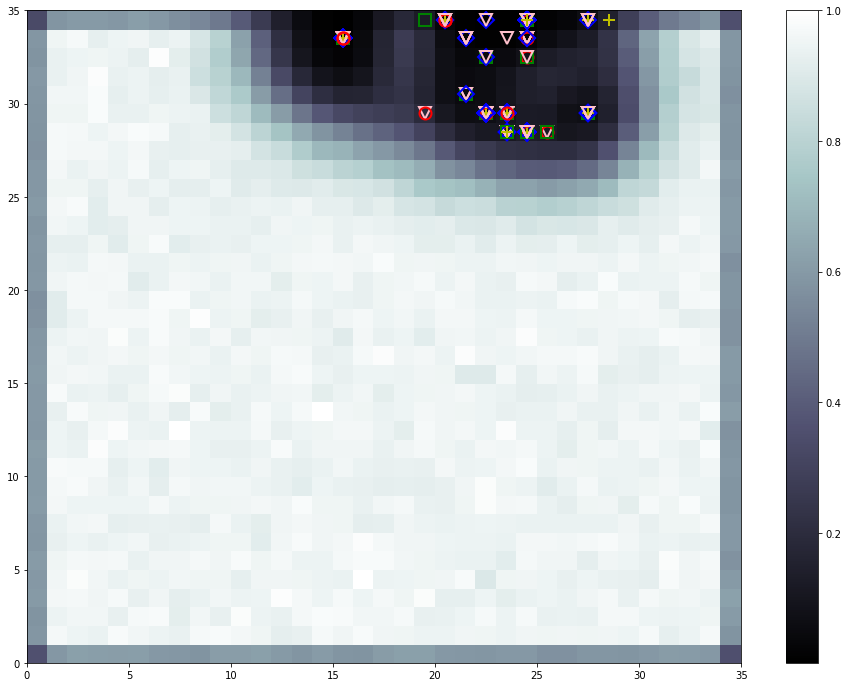

In [53]:
plot_som(som_og, data[0:n, :], target[0:n])

# Tree-based feature selection

In [54]:
clf = ExtraTreesClassifier()
clf.fit(data, target)

ExtraTreesClassifier()

In [55]:
sfm = SelectFromModel(clf, prefit=True)

In [58]:
data_benign_new = sfm.transform(data_benign)
data_ack_new = sfm.transform(data_ack)
data_scan_new = sfm.transform(data_scan)
data_syn_new = sfm.transform(data_syn)
data_udp_new = sfm.transform(data_udp)
data_new = sfm.transform(data)

In [59]:
print("Number of feature: ", data_new.shape[1])

Number of feature:  11


In [60]:
space = {
    'sigma': hp.uniform('sigma', 5, 10),
    'learning_rate': hp.uniform('learning_rate', 0.05, 5),
    'x': hp.uniform('x', 20, 50)
}

In [61]:
def som_fn(space):
    sig = space['sigma']
    learning_rate = space['learning_rate']
    x = int(space['x'])
    val = minisom.MiniSom(x=x,
                         y=x,
                         input_len=data_benign_new.shape[1],
                         sigma=sig,
                         learning_rate=learning_rate,
                         ).quantization_error(data_benign_new[0:100, :])
    print(space)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

In [63]:
trials = Trials()

In [64]:
best = fmin(fn=som_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=1200,
           trials=trials)

{'learning_rate': 0.4304096384865743, 'sigma': 8.638597822209222, 'x': 49.35624993190344}
0.8360671388612055                                      
{'learning_rate': 4.085053862105903, 'sigma': 5.039928432194882, 'x': 33.62229868170358}
0.8221874421715988                                                                
{'learning_rate': 3.9976712567746633, 'sigma': 9.875401478072288, 'x': 31.26631198322567}
0.7745352693126724                                                                
{'learning_rate': 0.6584551810033165, 'sigma': 5.407506732220913, 'x': 33.7938782330453}
0.8519978731726766                                                                
{'learning_rate': 3.3037297429291113, 'sigma': 5.549107675806478, 'x': 35.55861276648292}
0.8637611218302697                                                                
{'learning_rate': 2.4060108354695413, 'sigma': 5.05093585240978, 'x': 40.28605805891884}
0.8666316183975151                                                        

{'learning_rate': 2.006366355099149, 'sigma': 8.625582490045616, 'x': 23.30182777089008}
0.9004362346599932                                                                 
{'learning_rate': 3.1282788401347954, 'sigma': 6.596209086820744, 'x': 49.94441598116835}
0.8039914731182101                                                                 
{'learning_rate': 1.6491700275862848, 'sigma': 5.33289855882823, 'x': 48.86013605827991}
0.7707604058249903                                                                 
{'learning_rate': 4.064773193450084, 'sigma': 5.678461204202984, 'x': 43.42917008401999}
0.8314204184250729                                                                 
{'learning_rate': 4.849526740522185, 'sigma': 8.0262486664677, 'x': 32.653566937980365}
0.8645684629705034                                                                 
{'learning_rate': 4.455834947910988, 'sigma': 7.534367492844762, 'x': 44.704679273336666}
0.7499398215166876                           

0.7690211842696394                                                                  
{'learning_rate': 3.316747524402941, 'sigma': 9.348783323426568, 'x': 28.706085568994776}
0.8451144207490029                                                                  
{'learning_rate': 3.4700069782196774, 'sigma': 9.03962058404094, 'x': 21.464518639428277}
0.8959405198027747                                                                  
{'learning_rate': 2.9334809070316363, 'sigma': 9.919318868921621, 'x': 23.336184666318758}
0.8813143811870929                                                                  
{'learning_rate': 3.22968831461765, 'sigma': 8.843761501463465, 'x': 24.98374818445034}
0.9149041818690868                                                                  
{'learning_rate': 2.689967493452262, 'sigma': 9.776160469046411, 'x': 20.814515018074346}
0.8780930496005969                                                                  
{'learning_rate': 1.5844736713953913, 'si

0.7956498714015952                                                                  
{'learning_rate': 3.419509647632645, 'sigma': 7.38267382200252, 'x': 22.842433611512064}
0.721910626478702                                                                   
{'learning_rate': 3.2560458733772872, 'sigma': 7.16783725174001, 'x': 20.50575089149714}
0.9109833915859912                                                                  
{'learning_rate': 3.480521878490079, 'sigma': 7.624853699380433, 'x': 24.457170141897645}
0.8428276057227005                                                                  
{'learning_rate': 3.6454417312590484, 'sigma': 6.963484825829736, 'x': 22.81358001126631}
0.8935701616181333                                                                  
{'learning_rate': 3.758354200582405, 'sigma': 7.3664613354122865, 'x': 23.108884858488814}
0.8693978711818596                                                                  
{'learning_rate': 3.438529146442018, 'sig

0.8303560403809458                                                                  
{'learning_rate': 1.7241877884243695, 'sigma': 5.940645033856504, 'x': 33.61041535651675}
0.8446579323452821                                                                  
{'learning_rate': 2.4285262415147444, 'sigma': 5.4018546711623765, 'x': 28.095820422583508}
0.8753833816808642                                                                  
{'learning_rate': 2.062985801662301, 'sigma': 6.176637575747193, 'x': 27.30625883767051}
0.8736100460677294                                                                  
{'learning_rate': 2.2383658634384345, 'sigma': 9.352870820716907, 'x': 31.083806096414843}
0.7967446916593972                                                                  
{'learning_rate': 2.5527444378042254, 'sigma': 6.298963051070068, 'x': 23.685496703503183}
0.8671617039176407                                                                  
{'learning_rate': 1.149391262938699, 

0.9024427074550577                                                                  
{'learning_rate': 3.1967473424736763, 'sigma': 8.142808524699955, 'x': 28.686260538743454}
0.8649613020864456                                                                  
{'learning_rate': 1.438560142120613, 'sigma': 8.781734914589078, 'x': 34.579443897115475}
0.8453603031512471                                                                  
{'learning_rate': 3.417971772507952, 'sigma': 6.839217307922157, 'x': 35.525098848003765}
0.8221830527896863                                                                  
{'learning_rate': 2.0752411798030748, 'sigma': 6.492199654996999, 'x': 32.06907942786885}
0.889700211445259                                                                   
{'learning_rate': 3.677884169810849, 'sigma': 6.190271967624331, 'x': 22.77542868540359}
0.8277968481799098                                                                  
{'learning_rate': 2.631496207249743, 'si

0.8216153245962166                                                                  
{'learning_rate': 1.4740318884800476, 'sigma': 6.0640597750852665, 'x': 39.30790374278014}
0.8496206957755041                                                                  
{'learning_rate': 0.820442104528646, 'sigma': 6.233630722569017, 'x': 40.63205667847615}
0.8154119924543067                                                                  
{'learning_rate': 1.0593660741394935, 'sigma': 6.92925427167863, 'x': 38.52602372751836}
0.8157268121686514                                                                  
{'learning_rate': 1.2528030487973685, 'sigma': 7.421237180287042, 'x': 42.40776776323882}
0.809952643021238                                                                   
{'learning_rate': 0.4951716027000904, 'sigma': 6.514416897581567, 'x': 41.515813582403325}
0.8134810870648544                                                                  
{'learning_rate': 1.7874617968401723, 's

0.7877853455323529                                                                  
{'learning_rate': 4.135389153963039, 'sigma': 8.024450196768049, 'x': 35.0018911050077}
0.8403763907650779                                                                  
{'learning_rate': 1.9499001296077898, 'sigma': 6.432282482891997, 'x': 33.21549840894776}
0.8142016906864491                                                                  
{'learning_rate': 1.0993865730680983, 'sigma': 7.564647646508089, 'x': 25.902278803131615}
0.7807716074760094                                                                  
{'learning_rate': 2.006724710474423, 'sigma': 6.83496826380468, 'x': 36.84674459985641}
0.8619273421366959                                                                  
{'learning_rate': 0.8307441166824242, 'sigma': 7.256350629153992, 'x': 24.683028453664058}
0.9006958081425721                                                                  
{'learning_rate': 3.0376248405178714, 'sig

0.8010073262692933                                                                  
{'learning_rate': 4.3184061960858, 'sigma': 8.001471605517466, 'x': 30.903107316598252}
0.9002815898360177                                                                  
{'learning_rate': 1.467830488930163, 'sigma': 7.320277560107646, 'x': 39.07620910138806}
0.8262467556371915                                                                  
{'learning_rate': 3.5308591485437826, 'sigma': 7.801294753109183, 'x': 21.43091392954899}
0.8914154764539485                                                                  
{'learning_rate': 1.7939862269866163, 'sigma': 6.59929535239384, 'x': 37.45381800380459}
0.8202269075095998                                                                  
{'learning_rate': 3.252335587515687, 'sigma': 6.402106709437996, 'x': 22.889558160951292}
0.8747835738547007                                                                  
{'learning_rate': 4.126236113957923, 'sigma'

0.7799101783983119                                                                  
{'learning_rate': 2.4583111725170093, 'sigma': 6.149221905107684, 'x': 23.929092524321128}
0.8601350688364511                                                                  
{'learning_rate': 1.7126763833530734, 'sigma': 8.613134569854513, 'x': 36.623077150287244}
0.8022517855464906                                                                  
{'learning_rate': 1.356475096827493, 'sigma': 6.579331108719281, 'x': 27.64294983629384}
0.8740313667244665                                                                  
{'learning_rate': 4.205464905322572, 'sigma': 6.748188433445764, 'x': 35.89196310957657}
0.8975559378010698                                                                  
{'learning_rate': 2.0590103107933873, 'sigma': 6.665868868204632, 'x': 42.14442979871492}
0.7680331108627542                                                                  
{'learning_rate': 2.2646116524677935, 's

0.8790036354992283                                                                  
{'learning_rate': 2.804746039923738, 'sigma': 8.520571295683531, 'x': 41.75293869617122}
0.8145616496499192                                                                  
{'learning_rate': 1.65781737335821, 'sigma': 6.457544370804034, 'x': 39.261131402235335}
0.830202106285983                                                                   
{'learning_rate': 2.0572075132895598, 'sigma': 8.253131141914132, 'x': 45.648863356008896}
0.6481633339337979                                                                  
{'learning_rate': 1.761139383054009, 'sigma': 8.363797738740045, 'x': 47.31860083577136}
0.8387248897416006                                                                  
{'learning_rate': 1.8699846655743406, 'sigma': 8.799413567613476, 'x': 46.8988610579529}
0.8596917578096799                                                                  
{'learning_rate': 1.6089991518020352, 'sigm

0.8938601596728114                                                                   
{'learning_rate': 2.574984290694642, 'sigma': 7.192466666530269, 'x': 27.369361635258173}
0.8356856612797161                                                                   
{'learning_rate': 2.444296130436079, 'sigma': 7.429105498711632, 'x': 27.872593012741365}
0.8406504904453765                                                                   
{'learning_rate': 2.4217362819557104, 'sigma': 7.32895761459175, 'x': 32.433882486253886}
0.8629069501933502                                                                   
{'learning_rate': 2.3499300382372295, 'sigma': 7.0818830729113476, 'x': 26.497522645373977}
0.8310431490573194                                                                   
{'learning_rate': 2.2807702399818695, 'sigma': 7.247947522108086, 'x': 25.617521415635014}
0.8534804331395436                                                                   
{'learning_rate': 2.15870481971

0.7981956221810274                                                                   
{'learning_rate': 1.9389632439067859, 'sigma': 8.217952431373423, 'x': 46.459768185290564}
0.83832530264176                                                                     
{'learning_rate': 2.4868231538326495, 'sigma': 8.52265148954497, 'x': 48.34289621954276}
0.8376372806321166                                                                   
{'learning_rate': 3.547618802718661, 'sigma': 7.993090334750119, 'x': 49.811369699501654}
0.7944384690655605                                                                   
{'learning_rate': 2.1048203158610983, 'sigma': 8.041809717863808, 'x': 46.90195987616929}
0.8464009345564361                                                                   
{'learning_rate': 2.9996474003943483, 'sigma': 8.330040644951678, 'x': 47.841308235498715}
0.7143753798772596                                                                   
{'learning_rate': 4.0818815491028

In [65]:
print('Best: {}'.format(best))

Best: {'learning_rate': 2.0572075132895598, 'sigma': 8.253131141914132, 'x': 45.648863356008896}


In [66]:
som_turned = minisom.MiniSom(x=45,
                            y=45,
                            input_len=data_benign_new.shape[1],
                            sigma=8.253131141914132,
                            learning_rate=2.0572075132895598)

In [67]:
som_turned.train_random(data_benign_new, 1000)

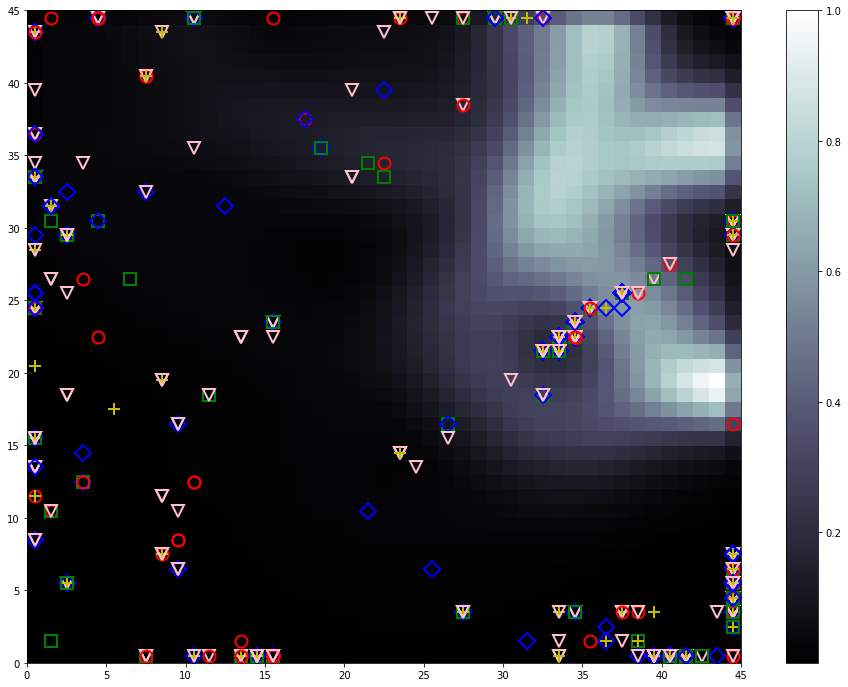

In [68]:
n = 10000
plot_som(som_turned, data_new[0:n, :], target[0:n])

## Somoclu

Flexible library with many options.

Pros:
- easy to identify clusters
- PCA initialization instead of random
- includes K-means clustering algorithm from sklearn
- evolving maps

Cons:
- long time to train.

In [69]:
som_somoclu = somoclu.Somoclu(n_columns=45,
                             n_rows=45,
                             std_coeff=8.2,
                             verbose=1)

In [70]:
som_somoclu.train(data_new[0:1000, :],
                 scale0=0.2,
                 scaleN=0.02)

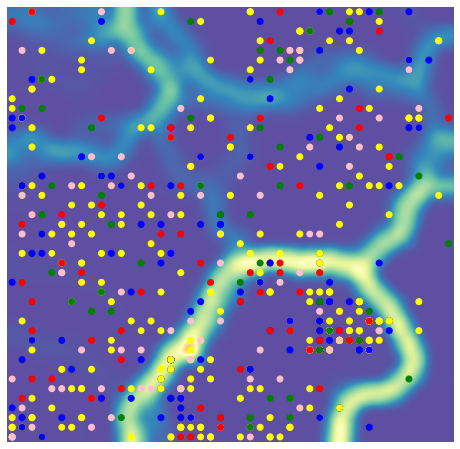

<module 'matplotlib.pyplot' from '/home/ladin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [71]:
colors = ['red', 'green', 'blue', 'pink', 'yellow']
color_list = [colors[t] for t in target[0:1000]]
som_somoclu.view_umatrix(bestmatches=True, bestmatchcolors=color_list)

# Anomaly detection with SOM and K-nearest neighbors

In [72]:
def get_anomalies(benign_metrics, anomaly_metrics, alpha=3, return_outliers=True):
    '''
    Get anomalies from evaluation metric
    '''
    limit = np.mean(benign_metrics)+np.std(benign_metrics)*alpha
    outliers = np.argwhere(np.abs(anomaly_metrics) > limit)
    print("Determined: ", len(outliers)/len(anomaly_metrics)*100, "% as anomaly")
    if return_outliers:
        return outliers

In [75]:
def minimize_anomaly(benign_metrics, anomaly_metrics, alpha=3):
    '''
    Objective function to be minimized durinig tuning
    calculates percent error in classifying anomalies based on steady state metrics.
    '''
    limit = np.mean(benign_metrics) + np.std(benign_metrics)*alpha
    outliers = np.argwhere(np.abs(anomaly_metrics)>limit)
    pct_anomaly = len(outliers)/len(anomaly_metrics)
    return 1 - pct_anomaly

In [77]:
# print(minimize_anomaly(benign_metrics=benign_metrics, anomaly_metrics=anomaly_metrics))

In [78]:
training = data_benign_new
evaluation = data_new

In [79]:
# initialize our anomaly detector with some arbitrary parameters
anomaly_detector = AnomalyDetection(shape=(10,10),
                                   input_size=training.shape[1],
                                   learning_rate=8,
                                   learning_decay=0.001,
                                   initial_radius=2,
                                   radius_decay=0.001,
                                   min_number_per_bmu=0,
                                   number_of_neighbors=3)
# fit the anomaly detector and apply to the evaluation data
anomaly_detector.fit(training, 5000)

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


array([[7.29138164e-05, 1.97237200e-08, 1.66817939e-07, ...,
        3.58341432e-07, 2.86627386e-06, 9.99999992e-01],
       [3.67638910e-05, 4.08309177e-08, 1.91592597e-07, ...,
        2.63720832e-07, 2.16618004e-06, 9.99999997e-01],
       [3.02866608e-06, 8.60183700e-09, 2.85593528e-08, ...,
        3.33672658e-08, 4.45462504e-07, 1.00000000e+00],
       ...,
       [3.13825978e-02, 6.04603488e-07, 6.95853521e-06, ...,
        3.62779119e-05, 6.57290756e-04, 9.99016284e-01],
       [4.05351176e-02, 1.72588326e-07, 2.51018605e-06, ...,
        9.18141651e-05, 1.26514697e-03, 9.98332207e-01],
       [4.87866588e-02, 1.44495847e-07, 1.16718287e-06, ...,
        9.91508234e-05, 1.57780482e-03, 9.97602882e-01]])

In [80]:
# set limits
benign_metrics = anomaly_detector.evaluate(data_benign_new)
alpha = 3
sd_benign = np.std(benign_metrics)
mean_benign = np.mean(benign_metrics)
lim_benign = mean_benign + alpha*sd_benign
pct_benign = np.percentile(benign_metrics, 99.7)

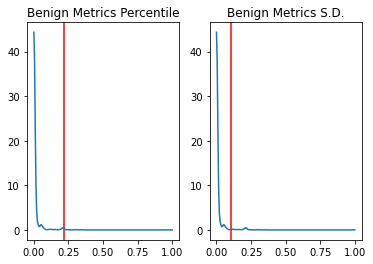

In [81]:
# visualizing benign
density = gaussian_kde(benign_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Benign Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Benign Metrics S.D.")
plt.show()

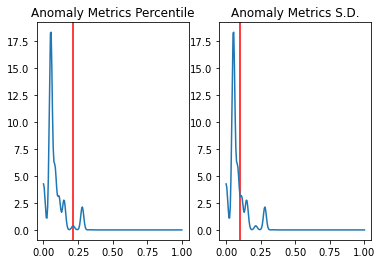

In [82]:
# Visualizing all anomalies
anomaly_metrics = anomaly_detector.evaluate(evaluation)
density = gaussian_kde(anomaly_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Anomaly Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Anomaly Metrics S.D.")
plt.show()

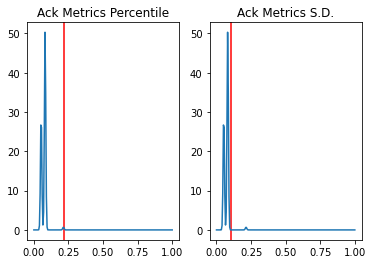

In [83]:
# Visualizing all anomalies
ack_metrics = anomaly_detector.evaluate(data_ack_new)
density = gaussian_kde(ack_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Ack Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Ack Metrics S.D.")
plt.show()

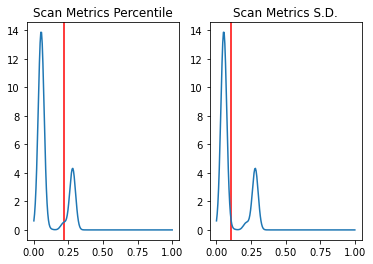

In [84]:
# Visualizing all anomalies
scan_metrics = anomaly_detector.evaluate(data_scan_new)
density = gaussian_kde(scan_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Scan Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Scan Metrics S.D.")
plt.show()

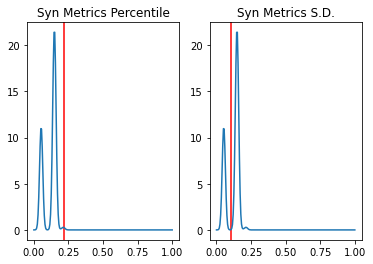

In [85]:
# Visualizing all anomalies
syn_metrics = anomaly_detector.evaluate(data_syn_new)
density = gaussian_kde(syn_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Syn Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Syn Metrics S.D.")
plt.show()

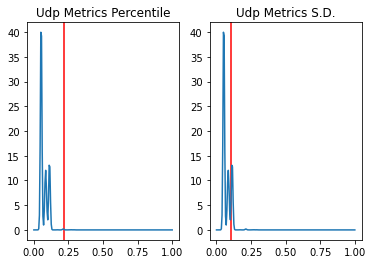

In [86]:
# Visualizing all anomalies
udp_metrics = anomaly_detector.evaluate(data_udp_new)
density = gaussian_kde(udp_metrics)
plt.subplot(121)
plt.axvline(x=pct_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Udp Metrics Percentile")
plt.subplot(122)
plt.axvline(x=lim_benign, color='red')
xs = np.linspace(0, 1, 200)
plt.plot(xs, density(xs))
plt.title("Udp Metrics S.D.")
plt.show()

In [88]:
metrics = [benign_metrics, anomaly_metrics, ack_metrics, scan_metrics, syn_metrics, udp_metrics]
metric_names = ['benign', 'all alnomalies', 'ack', 'scan', 'syn', 'udp']
alpha = 3
for metric, name in zip(metrics, metric_names):
    print(name)
    get_anomalies(benign_metrics, metric, alpha, False)

benign
Determined:  2.3 % as anomaly
all alnomalies
Determined:  22.8125 % as anomaly
ack
Determined:  0.8999999999999999 % as anomaly
scan
Determined:  25.8 % as anomaly
syn
Determined:  67.80000000000001 % as anomaly
udp
Determined:  20.633333333333333 % as anomaly


# Hyperparameter tuning

In [94]:
import time
start_time = time.time()

space = {
    'n_neighbors': hp.uniform('n_neighbors', 1, 3),
    'learning_rate': hp.uniform('learning_rate', 0.005, 10),
    'learning_decay': hp.uniform('learning_decay', 0.00001, 0.1),
    'initial_radius': hp.uniform('initial_radius', 1, 10),
    'radius_decay': hp.uniform('radius_decay', 0.00001, 0.1),
    'x': hp.uniform('x', 10, 50),
    'minNumberPerBmu': hp.uniform('minNumberPerBmu', 0, 10)
}

In [95]:
def anomaly_fn(space):
    n_neighbors = int(space['n_neighbors'])
    learning_rate = space['learning_rate']
    learning_decay = space['learning_decay']
    initial_radius = int(space['initial_radius'])
    radius_decay = space['radius_decay']
    x = int(space['x'])
    minNumberPerBmu = int(space['minNumberPerBmu'])
    
    anomaly_detector = AnomalyDetection(shape=(x, x),
                                       input_size=training.shape[1],
                                       learning_rate=learning_rate,
                                       learning_decay=learning_decay,
                                       initial_radius=initial_radius,
                                       radius_decay=radius_decay,
                                       min_number_per_bmu=minNumberPerBmu,
                                       number_of_neighbors=n_neighbors)
    anomaly_detector.fit(training, 5000)
    a_metrics = anomaly_detector.evaluate(evaluation)
    b_metrics = anomaly_detector.evaluate(training)
    val = minimize_anomaly(b_metrics, a_metrics, alpha=3)
    
    print(space)
    print(val)
    return {'loss': val, 'status': STATUS_OK}

In [107]:
trials = Trials()
best = fmin(fn=anomaly_fn,
           space=space,
           algo=tpe.suggest,
           max_evals=100,
           trials=trials)

{'initial_radius': 1.7108102810977575, 'learning_decay': 0.023690907192808912, 'learning_rate': 0.3603717700682639, 'minNumberPerBmu': 7.580151061668121, 'n_neighbors': 1.216751869278798, 'radius_decay': 0.025374299742700734, 'x': 35.58373289967227}
0.35662499999999997                                    
  1%|          | 1/100 [00:04<06:46,  4.10s/trial, best loss: 0.35662499999999997]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.425146863978644, 'learning_decay': 0.06856313659137725, 'learning_rate': 2.9787970849218546, 'minNumberPerBmu': 2.995116240981275, 'n_neighbors': 1.734611411333907, 'radius_decay': 0.06794463781130328, 'x': 20.307967502348436}
0.35650000000000004                                                               
  2%|▏         | 2/100 [00:06<04:58,  3.05s/trial, best loss: 0.35650000000000004]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.826485051730385, 'learning_decay': 0.06472936412844622, 'learning_rate': 2.554286561912157, 'minNumberPerBmu': 0.5948991569020945, 'n_neighbors': 1.0043803619201885, 'radius_decay': 0.04648266022452209, 'x': 40.20892096617439}
0.14249999999999996                                                               
  3%|▎         | 3/100 [00:11<06:29,  4.02s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.8764431397199814, 'learning_decay': 0.08491568211410334, 'learning_rate': 5.989182228348525, 'minNumberPerBmu': 0.5488652149087614, 'n_neighbors': 1.1938277429282957, 'radius_decay': 0.0365354776077817, 'x': 19.233925181685272}
0.33675                                                                           
  4%|▍         | 4/100 [00:13<05:23,  3.36s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.29641989530271, 'learning_decay': 0.09334137058944332, 'learning_rate': 4.283064771596757, 'minNumberPerBmu': 7.685553729942805, 'n_neighbors': 2.39241147911153, 'radius_decay': 0.020378803766194376, 'x': 37.40980510591571}
0.418875                                                                          
  5%|▌         | 5/100 [00:18<05:48,  3.67s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.841690289470481, 'learning_decay': 0.014641656040040014, 'learning_rate': 0.7330192650206476, 'minNumberPerBmu': 8.68782577927787, 'n_neighbors': 1.4535945039299214, 'radius_decay': 0.06540927580191411, 'x': 46.52762380603555}
0.35675                                                                           
  6%|▌         | 6/100 [00:23<06:52,  4.39s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.4025479749260152, 'learning_decay': 0.00907887575695103, 'learning_rate': 4.320042932575382, 'minNumberPerBmu': 4.637198873582711, 'n_neighbors': 2.7807025074460894, 'radius_decay': 0.09223930016097644, 'x': 27.800657820136788}
0.356375                                                                          
  7%|▋         | 7/100 [00:26<06:01,  3.89s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.266167322612, 'learning_decay': 0.07794021510448086, 'learning_rate': 3.64890891806855, 'minNumberPerBmu': 8.37670872814043, 'n_neighbors': 1.4027926450071733, 'radius_decay': 0.06266014001090754, 'x': 45.39312792922218}
0.35675                                                                           
  8%|▊         | 8/100 [00:32<06:46,  4.42s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.2972487847431737, 'learning_decay': 0.05875541789768973, 'learning_rate': 5.052087083688849, 'minNumberPerBmu': 2.457370087578381, 'n_neighbors': 1.9226179170566975, 'radius_decay': 0.03502850285601351, 'x': 42.97829452726575}
0.43737499999999996                                                               
  9%|▉         | 9/100 [00:37<06:55,  4.57s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.8258966007773596, 'learning_decay': 0.08780419368211403, 'learning_rate': 4.360484513089361, 'minNumberPerBmu': 0.19542704487984675, 'n_neighbors': 2.4257573554084866, 'radius_decay': 0.007899100753099568, 'x': 14.353119787834757}
0.6145                                                                            
 10%|█         | 10/100 [00:39<05:34,  3.72s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.9728546411345915, 'learning_decay': 0.08079787646757566, 'learning_rate': 1.9101977969194517, 'minNumberPerBmu': 1.833573627528916, 'n_neighbors': 1.833558694995338, 'radius_decay': 0.08060611238937232, 'x': 29.023732785701807}
0.277875                                                                           
 11%|█         | 11/100 [00:42<05:15,  3.55s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.664696369746926, 'learning_decay': 0.05807115863286211, 'learning_rate': 0.23226049080557093, 'minNumberPerBmu': 0.7318874690779875, 'n_neighbors': 1.2501858086097912, 'radius_decay': 0.038671143103357286, 'x': 46.39955105942681}
0.35662499999999997                                                                
 12%|█▏        | 12/100 [00:48<06:19,  4.32s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.370148708746995, 'learning_decay': 0.010206214223415588, 'learning_rate': 3.0520802274224583, 'minNumberPerBmu': 9.375479130480036, 'n_neighbors': 1.9273272078404078, 'radius_decay': 0.09147411605439779, 'x': 47.596596241007205}
0.27775000000000005                                                                
 13%|█▎        | 13/100 [00:54<06:55,  4.78s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.791450844915692, 'learning_decay': 0.05831131786184729, 'learning_rate': 7.644607098902927, 'minNumberPerBmu': 0.8726584653087499, 'n_neighbors': 1.027572543568175, 'radius_decay': 0.06559638098267079, 'x': 49.276599234575585}
0.35662499999999997                                                                
 14%|█▍        | 14/100 [01:00<07:38,  5.33s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.1969819917876645, 'learning_decay': 0.05775354100542545, 'learning_rate': 8.000160299287703, 'minNumberPerBmu': 0.9060077135092459, 'n_neighbors': 1.9169455732030733, 'radius_decay': 0.09472909484733048, 'x': 45.752082815373186}
0.29874999999999996                                                                
 15%|█▌        | 15/100 [01:06<07:44,  5.46s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.73000922016463, 'learning_decay': 0.09270287887789083, 'learning_rate': 3.0283094183621873, 'minNumberPerBmu': 4.504446338221642, 'n_neighbors': 2.2444613466715597, 'radius_decay': 0.09804372950347676, 'x': 16.461569190034563}
0.436875                                                                           
 16%|█▌        | 16/100 [01:08<06:08,  4.39s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.2915700257158704, 'learning_decay': 0.04841984295213534, 'learning_rate': 7.840719852428432, 'minNumberPerBmu': 7.140334394877011, 'n_neighbors': 1.313441515997512, 'radius_decay': 0.0225813060606707, 'x': 13.379738806366465}
0.36150000000000004                                                                
 17%|█▋        | 17/100 [01:10<05:00,  3.62s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.792856928590724, 'learning_decay': 0.09226286966907862, 'learning_rate': 6.086562496684081, 'minNumberPerBmu': 1.120153579881391, 'n_neighbors': 1.079931899637496, 'radius_decay': 0.0017593615255791426, 'x': 45.2684341850123}
0.443125                                                                           
 18%|█▊        | 18/100 [01:16<05:58,  4.37s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.316928654351281, 'learning_decay': 0.09783787875779129, 'learning_rate': 4.731267324559867, 'minNumberPerBmu': 5.405433901087608, 'n_neighbors': 1.8254947888790345, 'radius_decay': 0.06814458686605022, 'x': 38.53788016932357}
0.43700000000000006                                                                
 19%|█▉        | 19/100 [01:21<06:02,  4.48s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.172367786313322, 'learning_decay': 0.0017660393815543344, 'learning_rate': 7.171714956807254, 'minNumberPerBmu': 1.6558747423528275, 'n_neighbors': 2.6873246132763136, 'radius_decay': 0.013565106329724727, 'x': 44.05877764898989}
0.43700000000000006                                                                
 20%|██        | 20/100 [01:26<06:23,  4.80s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.014185100694194, 'learning_decay': 0.03702303393298485, 'learning_rate': 9.462321325994964, 'minNumberPerBmu': 6.055564851110045, 'n_neighbors': 1.6225774852457437, 'radius_decay': 0.05037113464579722, 'x': 33.11642948793313}
0.357125                                                                           
 21%|██        | 21/100 [01:30<05:59,  4.56s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.6577622445777935, 'learning_decay': 0.03521751498648955, 'learning_rate': 1.2925284926648004, 'minNumberPerBmu': 9.534908310720649, 'n_neighbors': 2.111850276242768, 'radius_decay': 0.05038706592619969, 'x': 40.231967445928014}
0.27749999999999997                                                                
 22%|██▏       | 22/100 [01:35<06:13,  4.79s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.943331493848227, 'learning_decay': 0.03415994983593017, 'learning_rate': 1.8859548212493589, 'minNumberPerBmu': 3.192810833673688, 'n_neighbors': 2.1573709765750335, 'radius_decay': 0.05025608917277091, 'x': 39.8985650791136}
0.277625                                                                           
 23%|██▎       | 23/100 [01:40<06:13,  4.85s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.892284681605634, 'learning_decay': 0.04400481290718099, 'learning_rate': 1.5344534807897214, 'minNumberPerBmu': 3.7736837805481853, 'n_neighbors': 2.5256567211916243, 'radius_decay': 0.044769148588119506, 'x': 33.54115686084042}
0.435875                                                                           
 24%|██▍       | 24/100 [01:44<05:48,  4.59s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.909985938037668, 'learning_decay': 0.028141622781166716, 'learning_rate': 1.5959923188450014, 'minNumberPerBmu': 9.483529392268853, 'n_neighbors': 2.130041671512139, 'radius_decay': 0.05627340295764735, 'x': 24.501141046360647}
0.35662499999999997                                                                
 25%|██▌       | 25/100 [01:47<05:00,  4.01s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.930719679645033, 'learning_decay': 0.06893218865752193, 'learning_rate': 1.1681620449448107, 'minNumberPerBmu': 5.770890577877773, 'n_neighbors': 1.6055968427172231, 'radius_decay': 0.08207748666811845, 'x': 40.56262800571824}
0.35675                                                                            
 26%|██▌       | 26/100 [01:52<05:11,  4.21s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.982660298952704, 'learning_decay': 0.06829378009312004, 'learning_rate': 2.4581404302692453, 'minNumberPerBmu': 6.49634177455278, 'n_neighbors': 2.8726952120901528, 'radius_decay': 0.07576918504715394, 'x': 32.05878950688357}
0.34225000000000005                                                                
 27%|██▋       | 27/100 [01:55<04:53,  4.03s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.865603063179808, 'learning_decay': 0.03954990534237169, 'learning_rate': 0.9002861691164585, 'minNumberPerBmu': 9.824066843700134, 'n_neighbors': 2.044170020021686, 'radius_decay': 0.029160650275510076, 'x': 41.00245912223995}
0.43674999999999997                                                                
 28%|██▊       | 28/100 [02:00<05:05,  4.25s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.652276839882282, 'learning_decay': 0.025057365357809606, 'learning_rate': 0.056567714825852766, 'minNumberPerBmu': 6.78317641718678, 'n_neighbors': 2.5997030926746647, 'radius_decay': 0.05794320535323713, 'x': 36.466314449076584}
0.357125                                                                           
 29%|██▉       | 29/100 [02:04<05:00,  4.23s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.148623966633723, 'learning_decay': 0.017592842935664786, 'learning_rate': 0.006647298231956977, 'minNumberPerBmu': 3.883469262436874, 'n_neighbors': 2.2540209871556747, 'radius_decay': 0.043725492546341206, 'x': 35.11290787270572}
1.0                                                                                
 30%|███       | 30/100 [02:08<04:50,  4.14s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.267837144130351, 'learning_decay': 0.05067142947034495, 'learning_rate': 2.4896610887448762, 'minNumberPerBmu': 8.12763418201346, 'n_neighbors': 2.952890560224156, 'radius_decay': 0.02844188623368157, 'x': 25.880971669930894}
0.277875                                                                           
 31%|███       | 31/100 [02:11<04:16,  3.72s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.101230442327532, 'learning_decay': 0.0315464483461486, 'learning_rate': 3.6752325804372554, 'minNumberPerBmu': 0.029222721785814088, 'n_neighbors': 1.703486476260891, 'radius_decay': 0.0732254570361059, 'x': 30.87807304706073}
0.35675                                                                            
 32%|███▏      | 32/100 [02:15<04:10,  3.68s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.544935179469218, 'learning_decay': 0.07130719455392405, 'learning_rate': 5.532333808267552, 'minNumberPerBmu': 3.0469258713008296, 'n_neighbors': 1.520983673669083, 'radius_decay': 0.056947831128138164, 'x': 49.41556844084569}
0.43700000000000006                                                                
 33%|███▎      | 33/100 [02:21<05:01,  4.49s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.56484015719973, 'learning_decay': 0.050433560729309594, 'learning_rate': 3.6452858224491216, 'minNumberPerBmu': 2.312412967150395, 'n_neighbors': 2.2855933478335624, 'radius_decay': 0.04215355098600932, 'x': 22.24058117733198}
0.35675                                                                            
 34%|███▍      | 34/100 [02:23<04:15,  3.87s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.651362281958496, 'learning_decay': 0.06346347151838014, 'learning_rate': 2.4154710434188704, 'minNumberPerBmu': 8.914455659981257, 'n_neighbors': 1.1316288505777967, 'radius_decay': 0.03407264129011202, 'x': 10.27511954158306}
0.277875                                                                           
 35%|███▌      | 35/100 [02:25<03:27,  3.19s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.384326224965615, 'learning_decay': 0.02109775060115833, 'learning_rate': 1.0203376973856124, 'minNumberPerBmu': 7.562000638179688, 'n_neighbors': 2.4495549069785203, 'radius_decay': 0.014510043439251816, 'x': 42.4333717021537}
0.27749999999999997                                                                
 36%|███▌      | 36/100 [02:30<03:58,  3.72s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.837186063161319, 'learning_decay': 0.016797001369120185, 'learning_rate': 0.7152710412854673, 'minNumberPerBmu': 7.686469364267786, 'n_neighbors': 2.4146606095032204, 'radius_decay': 0.01807967252080157, 'x': 35.084323553796665}
0.35662499999999997                                                                
 37%|███▋      | 37/100 [02:34<03:58,  3.79s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.303075273541571, 'learning_decay': 0.044041553700592324, 'learning_rate': 3.5171074318916182, 'minNumberPerBmu': 4.95364665111786, 'n_neighbors': 2.0528224263954185, 'radius_decay': 0.053316315894624974, 'x': 38.00080918891025}
0.43700000000000006                                                                
 38%|███▊      | 38/100 [02:39<04:15,  4.13s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.9098679836741308, 'learning_decay': 0.07535132884830968, 'learning_rate': 0.5223036078535164, 'minNumberPerBmu': 7.480734198558323, 'n_neighbors': 2.8336309978964733, 'radius_decay': 0.0022415401689996825, 'x': 42.721581212275325}
0.443125                                                                           
 39%|███▉      | 39/100 [02:44<04:32,  4.46s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.183567848891498, 'learning_decay': 0.05362468498299111, 'learning_rate': 6.241689112485005, 'minNumberPerBmu': 4.2439681357135814, 'n_neighbors': 1.403875004165446, 'radius_decay': 0.08462953589412414, 'x': 28.037910646444807}
0.32675                                                                            
 40%|████      | 40/100 [02:48<04:11,  4.18s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.2166581306134425, 'learning_decay': 0.021054157057685374, 'learning_rate': 4.094213095251893, 'minNumberPerBmu': 8.867660069536461, 'n_neighbors': 2.991220537375178, 'radius_decay': 0.008533077242896786, 'x': 49.672041088531635}
0.25725                                                                            
 41%|████      | 41/100 [02:55<04:56,  5.03s/trial, best loss: 0.14249999999999996]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.043514156563557, 'learning_decay': 0.00580736659565571, 'learning_rate': 5.354973091908459, 'minNumberPerBmu': 8.69120243923214, 'n_neighbors': 2.9636582352160503, 'radius_decay': 0.0063361680419867505, 'x': 49.90443520587601}
0.12075000000000002                                                                
 42%|████▏     | 42/100 [03:01<05:20,  5.53s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.8492905354982474, 'learning_decay': 0.007052674469656739, 'learning_rate': 6.654820471823991, 'minNumberPerBmu': 2.33670971526096, 'n_neighbors': 2.7293306322016813, 'radius_decay': 0.008652248972062682, 'x': 47.91317272648582}
0.763375                                                                           
 43%|████▎     | 43/100 [03:07<05:24,  5.70s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.3565823164063295, 'learning_decay': 0.08462375881432022, 'learning_rate': 8.86334243716372, 'minNumberPerBmu': 1.4480033749604475, 'n_neighbors': 1.2147845727594304, 'radius_decay': 0.027193246156432573, 'x': 47.53899594082446}
0.43674999999999997                                                                
 44%|████▍     | 44/100 [03:13<05:23,  5.78s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.490165148606239, 'learning_decay': 0.07735386211572128, 'learning_rate': 5.095044733103241, 'minNumberPerBmu': 0.3078209492256225, 'n_neighbors': 1.3300713623453806, 'radius_decay': 0.08829544475598917, 'x': 44.44719635950062}
0.35650000000000004                                                                
 45%|████▌     | 45/100 [03:19<05:17,  5.78s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.366227423441308, 'learning_decay': 0.06238566235989748, 'learning_rate': 5.329077443530708, 'minNumberPerBmu': 8.093316807966353, 'n_neighbors': 1.7835910390507985, 'radius_decay': 0.03456644448391705, 'x': 38.80452363677823}
0.851125                                                                           
 46%|████▌     | 46/100 [03:23<04:48,  5.34s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.7900023259800375, 'learning_decay': 0.0004930196641194581, 'learning_rate': 4.533686617530599, 'minNumberPerBmu': 6.192627358792722, 'n_neighbors': 1.5092180967563418, 'radius_decay': 0.024005568964027925, 'x': 29.916790309742098}
0.6154999999999999                                                                 
 47%|████▋     | 47/100 [03:27<04:07,  4.67s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.64787030875977, 'learning_decay': 0.09979364333514332, 'learning_rate': 5.757625466294128, 'minNumberPerBmu': 5.188271636449453, 'n_neighbors': 2.627623325335567, 'radius_decay': 0.07217264084140466, 'x': 18.947325338836585}
0.35675                                                                            
 48%|████▊     | 48/100 [03:29<03:23,  3.91s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.297610479443786, 'learning_decay': 0.07373191977626092, 'learning_rate': 6.894523827780854, 'minNumberPerBmu': 3.5691104726794984, 'n_neighbors': 1.0256938383619696, 'radius_decay': 0.06112987161551773, 'x': 46.91179292484669}
0.7248749999999999                                                                 
 49%|████▉     | 49/100 [03:35<03:49,  4.50s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.210329076724581, 'learning_decay': 0.08751785636067569, 'learning_rate': 4.067546698320373, 'minNumberPerBmu': 9.990815223872385, 'n_neighbors': 1.9090972904565908, 'radius_decay': 0.004652647867989489, 'x': 41.96536825015698}
0.40525                                                                            
 50%|█████     | 50/100 [03:39<03:48,  4.58s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.140966232514277, 'learning_decay': 0.08135637684592309, 'learning_rate': 8.272433929112957, 'minNumberPerBmu': 2.754347317859744, 'n_neighbors': 2.352825881271392, 'radius_decay': 0.038235575188642006, 'x': 36.66787155407174}
0.5037499999999999                                                                 
 51%|█████     | 51/100 [03:43<03:37,  4.43s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.537661907688191, 'learning_decay': 0.011095833051972724, 'learning_rate': 4.821335460603552, 'minNumberPerBmu': 5.646853963044772, 'n_neighbors': 2.9036418494118914, 'radius_decay': 0.04740379759784233, 'x': 48.647458106142764}
0.43674999999999997                                                                
 52%|█████▏    | 52/100 [03:50<03:58,  4.96s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.15901605948838, 'learning_decay': 0.004335131706855241, 'learning_rate': 3.1972128370402393, 'minNumberPerBmu': 4.673450885590657, 'n_neighbors': 1.3195951227585505, 'radius_decay': 0.021271760152439416, 'x': 43.65291831583074}
0.290625                                                                           
 53%|█████▎    | 53/100 [03:55<03:55,  5.02s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.69361792766617, 'learning_decay': 0.06546396365674616, 'learning_rate': 7.466742769023817, 'minNumberPerBmu': 1.2792064701878658, 'n_neighbors': 1.1311507861499766, 'radius_decay': 0.015562376007314728, 'x': 45.74995299964726}
0.289875                                                                           
 54%|█████▍    | 54/100 [04:00<03:57,  5.16s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.676024645186998, 'learning_decay': 0.055557223742265356, 'learning_rate': 2.8231288920628805, 'minNumberPerBmu': 1.896427305323856, 'n_neighbors': 2.516723608665849, 'radius_decay': 0.03229727814405477, 'x': 33.50772553209149}
0.28137500000000004                                                                
 55%|█████▌    | 55/100 [04:04<03:31,  4.71s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.0273108444824213, 'learning_decay': 0.04281876853641116, 'learning_rate': 8.396513650462044, 'minNumberPerBmu': 6.810005835074895, 'n_neighbors': 1.6796906016580966, 'radius_decay': 0.010490014080958239, 'x': 39.07758880489122}
0.41300000000000003                                                                
 56%|█████▌    | 56/100 [04:08<03:24,  4.65s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.639816546703684, 'learning_decay': 0.047367570900817994, 'learning_rate': 6.318155700178048, 'minNumberPerBmu': 8.504176824800064, 'n_neighbors': 1.9845181047135825, 'radius_decay': 0.06362454151325958, 'x': 25.577776238535783}
0.354375                                                                           
 57%|█████▋    | 57/100 [04:11<02:55,  4.07s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.7799720060368225, 'learning_decay': 0.061146170577323126, 'learning_rate': 1.9954785358588258, 'minNumberPerBmu': 0.5519957643099055, 'n_neighbors': 2.1804175155825547, 'radius_decay': 0.04073056849109354, 'x': 44.689746340289744}
0.43700000000000006                                                                
 58%|█████▊    | 58/100 [04:17<03:11,  4.57s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.5620387602434536, 'learning_decay': 0.029788040432888126, 'learning_rate': 9.486115945007228, 'minNumberPerBmu': 4.143074905112703, 'n_neighbors': 1.5578778370560102, 'radius_decay': 0.07805456269404677, 'x': 31.332056746119527}
0.29737499999999994                                                                
 59%|█████▉    | 59/100 [04:20<02:52,  4.21s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.02207071840064, 'learning_decay': 0.08151564611616645, 'learning_rate': 9.98918110819943, 'minNumberPerBmu': 9.145373525250534, 'n_neighbors': 2.806009584646925, 'radius_decay': 0.09784213963574534, 'x': 41.33410323292844}
0.35650000000000004                                                                
 60%|██████    | 60/100 [04:25<02:59,  4.48s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.52590769484869, 'learning_decay': 0.09201329006314611, 'learning_rate': 3.2756207831561794, 'minNumberPerBmu': 3.2909165694582514, 'n_neighbors': 1.7628775474855192, 'radius_decay': 0.0181090490120008, 'x': 49.808552771429625}
0.25949999999999995                                                                
 61%|██████    | 61/100 [04:32<03:16,  5.04s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.121681703898752, 'learning_decay': 0.09652530430609124, 'learning_rate': 2.6846834611389863, 'minNumberPerBmu': 6.194469216859165, 'n_neighbors': 2.7553617309329983, 'radius_decay': 0.07015092399459155, 'x': 34.756764822593325}
0.357                                                                              
 62%|██████▏   | 62/100 [04:36<02:57,  4.68s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.582866869965262, 'learning_decay': 0.06668276883854876, 'learning_rate': 2.003255885459832, 'minNumberPerBmu': 1.9282519047218298, 'n_neighbors': 2.3455943420990835, 'radius_decay': 0.005626391589764791, 'x': 37.14491887480848}
0.27412499999999995                                                                
 63%|██████▎   | 63/100 [04:40<02:47,  4.52s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.388794449630073, 'learning_decay': 0.03900206235734633, 'learning_rate': 4.005113151893929, 'minNumberPerBmu': 7.237185328179465, 'n_neighbors': 1.864337465455335, 'radius_decay': 0.04655327467734608, 'x': 20.956996865470312}
0.15737500000000004                                                                
 64%|██████▍   | 64/100 [04:42<02:17,  3.82s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.971289508033706, 'learning_decay': 0.02540884693952062, 'learning_rate': 5.793524545493648, 'minNumberPerBmu': 2.7370720066590506, 'n_neighbors': 2.63319902583408, 'radius_decay': 0.0010845138500036322, 'x': 46.176750476600695}
0.399875                                                                           
 65%|██████▌   | 65/100 [04:48<02:32,  4.36s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.363077496638549, 'learning_decay': 0.040900706865375835, 'learning_rate': 3.966606762966143, 'minNumberPerBmu': 7.0586707082821905, 'n_neighbors': 1.4360381955455581, 'radius_decay': 0.04565712251072044, 'x': 13.477767940989951}
0.6154999999999999                                                                 
 66%|██████▌   | 66/100 [04:49<02:01,  3.57s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.803643612524713, 'learning_decay': 0.036946754570733265, 'learning_rate': 5.170475548598035, 'minNumberPerBmu': 8.170851635189292, 'n_neighbors': 1.1039927835876377, 'radius_decay': 0.03139307700283699, 'x': 17.846859135960518}
0.6148750000000001                                                                 
 67%|██████▋   | 67/100 [04:51<01:41,  3.09s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.402597025758151, 'learning_decay': 0.013999187982480787, 'learning_rate': 4.548351758548219, 'minNumberPerBmu': 7.865102093662281, 'n_neighbors': 1.2552352177515393, 'radius_decay': 0.054251273671956195, 'x': 22.407836129666546}
0.32662500000000005                                                                
 68%|██████▊   | 68/100 [04:54<01:31,  2.86s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 1.0196127236212083, 'learning_decay': 0.05561828425259356, 'learning_rate': 3.9015946607185015, 'minNumberPerBmu': 9.743641639164656, 'n_neighbors': 1.8401462743450372, 'radius_decay': 0.060942322711712675, 'x': 11.633047619697706}
0.35650000000000004                                                                
 69%|██████▉   | 69/100 [04:55<01:16,  2.47s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.700913739016469, 'learning_decay': 0.046298201351291805, 'learning_rate': 1.5312951641422798, 'minNumberPerBmu': 7.173170826199199, 'n_neighbors': 2.060853029729898, 'radius_decay': 0.03937143060695331, 'x': 15.895651413346798}
0.35675                                                                            
 70%|███████   | 70/100 [04:57<01:08,  2.29s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 3.4458544593985208, 'learning_decay': 0.052656440270539215, 'learning_rate': 6.488278502294644, 'minNumberPerBmu': 8.66235314880377, 'n_neighbors': 1.63943477141935, 'radius_decay': 0.048515769091443665, 'x': 22.41794568048269}
0.3125                                                                             
 71%|███████   | 71/100 [04:59<01:07,  2.32s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.9451920784653565, 'learning_decay': 0.07038161268197568, 'learning_rate': 4.321555364806396, 'minNumberPerBmu': 6.627668341714583, 'n_neighbors': 2.5095201502790765, 'radius_decay': 0.05233805236577185, 'x': 20.980900557755188}
0.494375                                                                           
 72%|███████▏  | 72/100 [05:02<01:04,  2.29s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.49967039630701, 'learning_decay': 0.0060293413322754785, 'learning_rate': 2.277687165292416, 'minNumberPerBmu': 5.73023979032386, 'n_neighbors': 2.2181310953996487, 'radius_decay': 0.025848153680268323, 'x': 27.75500436625052}
0.13587499999999997                                                                
 73%|███████▎  | 73/100 [05:04<01:06,  2.46s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.752738608733308, 'learning_decay': 0.007052539190534789, 'learning_rate': 2.2543896553341445, 'minNumberPerBmu': 5.802033709456634, 'n_neighbors': 2.1783872015235417, 'radius_decay': 0.025006670971088385, 'x': 26.818059981415757}
0.443875                                                                           
 74%|███████▍  | 74/100 [05:07<01:06,  2.56s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.119818762332883, 'learning_decay': 0.020373310995222174, 'learning_rate': 0.22587103326870084, 'minNumberPerBmu': 4.705573292140146, 'n_neighbors': 2.579397644763363, 'radius_decay': 0.0372569700631709, 'x': 23.951315565563274}
0.41712499999999997                                                                
 75%|███████▌  | 75/100 [05:10<01:03,  2.53s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.234757306540633, 'learning_decay': 0.013280120892300983, 'learning_rate': 3.4552686863069217, 'minNumberPerBmu': 5.50013675170661, 'n_neighbors': 2.6829853426835664, 'radius_decay': 0.011935787414932982, 'x': 28.47597536354602}
0.29574999999999996                                                                
 76%|███████▌  | 76/100 [05:13<01:04,  2.67s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.445787533391533, 'learning_decay': 0.00313760170313484, 'learning_rate': 2.88252195083457, 'minNumberPerBmu': 5.088831184764936, 'n_neighbors': 2.986668500165806, 'radius_decay': 0.02966684568012383, 'x': 32.41718143914946}
0.443125                                                                           
 77%|███████▋  | 77/100 [05:16<01:06,  2.91s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.9930009683091505, 'learning_decay': 0.03220373125966974, 'learning_rate': 5.4649510747834436, 'minNumberPerBmu': 3.4991808807101945, 'n_neighbors': 2.2963986322049905, 'radius_decay': 0.01904080953516135, 'x': 29.748638156215232}
0.44337499999999996                                                                
 78%|███████▊  | 78/100 [05:19<01:05,  2.95s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.997142552988063, 'learning_decay': 0.060234188988994596, 'learning_rate': 0.4725280115110484, 'minNumberPerBmu': 4.195564643583876, 'n_neighbors': 1.9616371021439591, 'radius_decay': 0.02599302452843589, 'x': 35.6257872117355}
0.436875                                                                           
 79%|███████▉  | 79/100 [05:23<01:08,  3.28s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.588447380859737, 'learning_decay': 0.01842633208849861, 'learning_rate': 1.2518505322082538, 'minNumberPerBmu': 6.441175456356579, 'n_neighbors': 2.4711148904080997, 'radius_decay': 0.01632527958635531, 'x': 27.57479099735388}
0.44337499999999996                                                                
 80%|████████  | 80/100 [05:26<01:03,  3.18s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.128763786593822, 'learning_decay': 0.027065116412219595, 'learning_rate': 6.934675511812306, 'minNumberPerBmu': 0.9828925729346425, 'n_neighbors': 2.2254098534838302, 'radius_decay': 0.043025704583465614, 'x': 24.499395238450504}
0.85075                                                                            
 81%|████████  | 81/100 [05:29<00:57,  3.05s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.814214537997554, 'learning_decay': 0.009885388375772977, 'learning_rate': 1.7076034426014868, 'minNumberPerBmu': 3.9012061906231517, 'n_neighbors': 2.902277573591789, 'radius_decay': 0.02227561996352686, 'x': 31.005351431103268}
0.281625                                                                           
 82%|████████▏ | 82/100 [05:32<00:56,  3.14s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.5397695668109, 'learning_decay': 0.00505684592880742, 'learning_rate': 4.832310467992713, 'minNumberPerBmu': 9.13101181125747, 'n_neighbors': 2.359927451526931, 'radius_decay': 0.012005609172852077, 'x': 39.7514143838814}
0.277625                                                                           
 83%|████████▎ | 83/100 [05:37<01:01,  3.63s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.401623705172302, 'learning_decay': 0.07843074869030987, 'learning_rate': 2.3336767645085996, 'minNumberPerBmu': 5.251218625831615, 'n_neighbors': 2.6927192117741026, 'radius_decay': 0.00520776602209096, 'x': 43.525199103070776}
0.73925                                                                            
 84%|████████▍ | 84/100 [05:42<01:05,  4.07s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 8.939060223995229, 'learning_decay': 0.034356258936286105, 'learning_rate': 0.7210471259566811, 'minNumberPerBmu': 4.484438694278271, 'n_neighbors': 2.127255725696245, 'radius_decay': 0.06682936706549483, 'x': 33.79705660755937}
0.277875                                                                           
 85%|████████▌ | 85/100 [05:46<00:59,  3.94s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.979593015897349, 'learning_decay': 0.02391686664990944, 'learning_rate': 5.938286110567619, 'minNumberPerBmu': 5.933509621370536, 'n_neighbors': 2.566845079338226, 'radius_decay': 0.02695876733242357, 'x': 37.619116519118045}
0.35650000000000004                                                                
 86%|████████▌ | 86/100 [05:50<00:56,  4.01s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 9.346489846640628, 'learning_decay': 0.0017943900531309257, 'learning_rate': 2.6107490314764514, 'minNumberPerBmu': 2.7563582759658347, 'n_neighbors': 1.3787867467208568, 'radius_decay': 0.035653270635035074, 'x': 48.35889844533803}
0.44337499999999996                                                                
 87%|████████▋ | 87/100 [05:56<00:59,  4.60s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.268176635560273, 'learning_decay': 0.00020279494666575974, 'learning_rate': 7.493148851329177, 'minNumberPerBmu': 8.359051514724861, 'n_neighbors': 1.4898494589502387, 'radius_decay': 0.03179871077694729, 'x': 23.500312101253776}
0.124                                                                              
 88%|████████▊ | 88/100 [05:58<00:47,  3.96s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.017099469735218, 'learning_decay': 0.007711380156795973, 'learning_rate': 7.291269865144679, 'minNumberPerBmu': 7.869829840020752, 'n_neighbors': 1.7222762276051193, 'radius_decay': 0.020809917716006036, 'x': 16.75235138377856}
0.8125                                                                             
 89%|████████▉ | 89/100 [06:00<00:36,  3.35s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.052444457648987, 'learning_decay': 0.00011635115103684325, 'learning_rate': 8.171914186758322, 'minNumberPerBmu': 8.431387915076348, 'n_neighbors': 1.4845318831186702, 'radius_decay': 0.0029601115164247377, 'x': 23.526673625650215}
0.618                                                                              
 90%|█████████ | 90/100 [06:03<00:30,  3.07s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.675870452950854, 'learning_decay': 0.0162393902196175, 'learning_rate': 8.883647325801961, 'minNumberPerBmu': 9.646038972936148, 'n_neighbors': 1.590767602105131, 'radius_decay': 0.031230760800377205, 'x': 26.13126576634361}
0.25025                                                                            
 91%|█████████ | 91/100 [06:06<00:26,  2.99s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.2993556978965906, 'learning_decay': 0.012078419044778552, 'learning_rate': 7.870489175426947, 'minNumberPerBmu': 9.099487055219797, 'n_neighbors': 2.0149046665052324, 'radius_decay': 0.007629940830072679, 'x': 18.257678652107952}
0.278                                                                              
 92%|█████████▏| 92/100 [06:08<00:21,  2.72s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.822278945338256, 'learning_decay': 0.00569895088235404, 'learning_rate': 7.6393544386542285, 'minNumberPerBmu': 9.355083624052067, 'n_neighbors': 2.0888511911435694, 'radius_decay': 0.023621407815737752, 'x': 15.255574549254682}
0.20337499999999997                                                                
 93%|█████████▎| 93/100 [06:09<00:17,  2.46s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 4.519434120767336, 'learning_decay': 2.0124179717691086e-05, 'learning_rate': 8.651753074483256, 'minNumberPerBmu': 8.7935089759212, 'n_neighbors': 1.2624666769404913, 'radius_decay': 0.03378465292975446, 'x': 19.36596259173419}
0.61425                                                                            
 94%|█████████▍| 94/100 [06:12<00:14,  2.35s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 2.4280339515731217, 'learning_decay': 0.0216547797442745, 'learning_rate': 6.9633296123148956, 'minNumberPerBmu': 7.3594711281404015, 'n_neighbors': 1.9027751853779025, 'radius_decay': 0.01290289476625445, 'x': 25.25345627738184}
0.793625                                                                           
 95%|█████████▌| 95/100 [06:14<00:12,  2.45s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 6.266567961434305, 'learning_decay': 0.015279607971308933, 'learning_rate': 9.545760503845647, 'minNumberPerBmu': 6.945009425273136, 'n_neighbors': 1.7749523829810343, 'radius_decay': 9.990018756292959e-05, 'x': 28.886308756317703}
0.771875                                                                           
 96%|█████████▌| 96/100 [06:17<00:10,  2.60s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.105339386254453, 'learning_decay': 0.018614829102091092, 'learning_rate': 9.125399636760893, 'minNumberPerBmu': 8.269177477061298, 'n_neighbors': 1.0762748471823036, 'radius_decay': 0.009678438598625005, 'x': 27.51820029497706}
0.6154999999999999                                                                 
 97%|█████████▋| 97/100 [06:20<00:08,  2.70s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 5.110590778532482, 'learning_decay': 0.008896013406330717, 'learning_rate': 6.12516730145102, 'minNumberPerBmu': 9.975282920415214, 'n_neighbors': 1.6544440208338154, 'radius_decay': 0.016334441393440136, 'x': 20.149521777235957}
0.615375                                                                           
 98%|█████████▊| 98/100 [06:23<00:05,  2.63s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.2846381166017204, 'learning_decay': 0.030937861785930335, 'learning_rate': 6.633423356071116, 'minNumberPerBmu': 7.913218987670208, 'n_neighbors': 1.5727965349486017, 'radius_decay': 0.02874969357818012, 'x': 10.85302383968412}
0.12487499999999996                                                                
 99%|█████████▉| 99/100 [06:24<00:02,  2.32s/trial, best loss: 0.12075000000000002]

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]



{'initial_radius': 7.819216632011994, 'learning_decay': 0.030598099371932384, 'learning_rate': 9.773469152557173, 'minNumberPerBmu': 7.838687794404441, 'n_neighbors': 1.5589606367573494, 'radius_decay': 0.04109841404910253, 'x': 13.495547272190079}
0.70275                                                                            
100%|██████████| 100/100 [06:26<00:00,  3.87s/trial, best loss: 0.12075000000000002]


In [108]:
print('Best: {}'.format(best))
elapsed_time = time.time() - start_time
print(elapsed_time, " seconds")

Best: {'initial_radius': 3.043514156563557, 'learning_decay': 0.00580736659565571, 'learning_rate': 5.354973091908459, 'minNumberPerBmu': 8.69120243923214, 'n_neighbors': 2.9636582352160503, 'radius_decay': 0.0063361680419867505, 'x': 49.90443520587601}
5365.05815243721  seconds


In [109]:
# {
#     'n_neighbors': 45,
#     'learning_rate': ,
#     'learning_decay': ,
#     'initial_radius': ,
#     'radius_decay': ,
#     'x': ,
#     'minNumberPerBmu': 
# }
best

{'initial_radius': 3.043514156563557,
 'learning_decay': 0.00580736659565571,
 'learning_rate': 5.354973091908459,
 'minNumberPerBmu': 8.69120243923214,
 'n_neighbors': 2.9636582352160503,
 'radius_decay': 0.0063361680419867505,
 'x': 49.90443520587601}

In [110]:
anomaly_detector_tuned = AnomalyDetection(shape=(50,50),
                                         input_size=training.shape[1],
                                         learning_rate=5,
                                         learning_decay=0.006,
                                         initial_radius=3,
                                         radius_decay=0.006,
                                         min_number_per_bmu=9,
                                         number_of_neighbors=3)
anomaly_detector_tuned.fit(training, 5000)

/home/ladin/Projects/research/botnet-traffic-analysis/SAD/kohonen_som.py:132: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  bmu_distance = bmu_distance[slc]


array([[ 6.11571091e-03,  5.56341207e-04, -8.36741831e-03,
        -7.49552848e-03,  5.78775249e-03, -2.17188634e-03,
         6.37503360e-03,  2.51285377e-02,  2.18524776e-02,
         1.21409641e-02,  5.79714393e-03],
       [-1.27706466e-02, -3.22374790e-05,  7.62028493e-04,
        -2.12883055e-03, -5.32199637e-03, -2.36750767e-03,
        -1.71829065e-04,  3.27274084e-01,  3.78433260e-01,
         4.08721606e-01,  3.75116767e-01],
       [ 2.60852300e-01,  3.47572359e-02,  3.01955728e-02,
         3.28194354e-02,  3.02103201e-02,  3.57611469e-02,
         4.09483893e-02,  1.32755642e-02,  1.27629619e-02,
         3.05458027e-02,  8.89378907e-01],
       [ 1.72163845e-01,  5.41139151e-03,  5.51308170e-03,
         1.13788239e-02,  5.41106893e-03,  5.51310669e-03,
         1.13788289e-02,  2.47382270e-03,  2.63836456e-03,
         8.57572166e-03,  9.57552834e-01],
       [ 4.02459106e-06,  2.90324439e-08,  4.49650493e-08,
         4.35986862e-07,  2.90324439e-08,  4.49650493e-08,
  

In [111]:
# calculate metrics
benign_metrics_tuned = anomaly_detector_tuned.evaluate(training)
anomaly_metrics_tuned = anomaly_detector_tuned.evaluate(evaluation)
ack_metrics_tuned = anomaly_detector_tuned.evaluate(data_ack_new)
scan_metrics_tuned = anomaly_detector_tuned.evaluate(data_scan_new)
syn_metrics_tuned = anomaly_detector_tuned.evaluate(data_syn_new)
udp_metrics_tuned = anomaly_detector_tuned.evaluate(data_udp_new)

In [114]:
metrics = [benign_metrics_tuned, anomaly_metrics_tuned,
          ack_metrics_tuned, scan_metrics_tuned,
          syn_metrics_tuned, udp_metrics_tuned]
metric_names = ['benign', 'all anomalies', 'ack', 'scan', 'syn', 'udp']
alpha = 3
for metric, name in zip(metrics, metric_names):
    print(name)
    get_anomalies(benign_metrics_tuned, metric, alpha, False)

benign
Determined:  3.6999999999999997 % as anomaly
all anomalies
Determined:  75.125 % as anomaly
ack
Determined:  37.5 % as anomaly
scan
Determined:  99.9 % as anomaly
syn
Determined:  100.0 % as anomaly
udp
Determined:  86.96666666666667 % as anomaly
